# Analysing mybinder.org launches

The first few cells download and massage the data. Later on we answer questions on which repositories are popular and such.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import datetime

import pandas as pd

In [2]:
index = pd.read_json("https://archive.analytics.mybinder.org/index.jsonl",
                     lines=True)

In [3]:
# get all days since start of 2019
now = datetime.datetime.now()
n = (now - datetime.datetime(2019, 1, 1)).days

# small range for previewing
#n = 30

frames = []
for idx, day in index.sort_index(ascending=False).iterrows():
    df = pd.read_json("https://archive.analytics.mybinder.org/{}".format(day['name']),
                      lines=True, )
    frames.append(df)
    if len(frames) > n:
        break
        
print(f"Fetched data for {n} days.")

Fetched data for 178 days.


In [4]:
df = pd.concat(frames)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
# make it easier to grab the ref
def get_repo(spec):
    s = spec.rsplit("/", 1)[0]
    if s.endswith('.git'):
        s = s[:-4]
    return s
df['repo'] = df['spec'].apply(get_repo) #lambda s: s.rsplit("/", 1)[0].replace(".git", ""))
df['org'] = df['spec'].apply(lambda s: s.split("/", 1)[0])
df['ref'] = df['spec'].apply(lambda s: s.rsplit("/", 1)[1])

In [6]:
# take a look at the data, does it look sensible?
df.sample(10)

,origin,provider,schema,spec,status,timestamp,version,repo,org,ref
4213,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-04-28 11:49:00,2,ipython/ipython-in-depth,ipython,master
2498,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-06-28 03:50:00,3,ipython/ipython-in-depth,ipython,master
1092,NaN,GitHub,binderhub.jupyter.org/launch,ComputoCienciasUniandes/FISI2028-201910/master,success,2019-04-03 02:22:00,2,ComputoCienciasUniandes/FISI2028-201910,ComputoCienciasUniandes,master
9971,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-05-31 19:05:00,2,ipython/ipython-in-depth,ipython,master
4994,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-02-05 11:03:00,1,ipython/ipython-in-depth,ipython,master
13361,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-03-20 19:45:00,1,ipython/ipython-in-depth,ipython,master
8003,NaN,GitHub,binderhub.jupyter.org/launch,ines/spacy-io-binder/live,success,2019-01-14 14:41:00,1,ines/spacy-io-binder,ines,live
10963,NaN,GitHub,binderhub.jupyter.org/launch,QISKit/qiskit-tutorial/master,success,2019-01-28 16:05:00,1,QISKit/qiskit-tutorial,QISKit,master
6616,NaN,GitHub,binderhub.jupyter.org/launch,ipython/ipython-in-depth/master,success,2019-02-01 14:01:00,1,ipython/ipython-in-depth,ipython,master
5845,gke.mybinder.org,GitHub,binderhub.jupyter.org/launch,binder-examples/r/master,success,2019-06-21 08:38:00,3,binder-examples/r,binder-examples,master


In [7]:
df = df.drop(columns=['schema', 'version', 'spec', 'status'])

In [8]:
df.head()

,origin,provider,timestamp,repo,org,ref
0,gke.mybinder.org,GitHub,2019-06-28 00:00:00,jupyterlab/jupyterlab-demo,jupyterlab,master
1,gke.mybinder.org,GitHub,2019-06-28 00:01:00,ipython/ipython-in-depth,ipython,master
2,gke.mybinder.org,GitHub,2019-06-28 00:01:00,ipython/ipython-in-depth,ipython,master
3,gke.mybinder.org,GitHub,2019-06-28 00:01:00,ipython/ipython-in-depth,ipython,master
4,gke.mybinder.org,GitHub,2019-06-28 00:01:00,jupyterlab/jupyterlab-demo,jupyterlab,master


## Monthly, weekly, daily active repos

In [9]:
df_ = df.set_index("timestamp")

In [10]:
def n_active_repos(period=30):
    """Unique active repos over the period
    
    With period=30 this gives monthly active repos
    With period=1 you get daily active repos
    """
    now = datetime.datetime.now()
    start = datetime.datetime(2019, 1, 1)
    days_since_start = (now - start).days

    data = []

    for n in range(days_since_start):
        s = start + datetime.timedelta(days=n)
        e = start + datetime.timedelta(days=n+period)
        if e > now:
            break

        # our "monthly" data
        monthly = df_.loc[s.isoformat():e.isoformat()]
        data.append(dict(timestamp=e, repos=len(set(monthly.repo))))
        
    return pd.DataFrame.from_records(data).set_index("timestamp")

In [11]:
monthly_active = n_active_repos(30)
weekly_active = n_active_repos(7)
daily_active = n_active_repos(1)

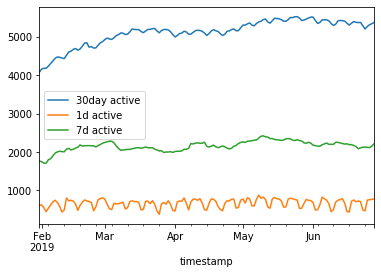

In [12]:
activity = pd.merge(monthly_active, daily_active,
                    suffixes=("_monthly", "_daily"), left_index=True, right_index=True)
activity = pd.merge(activity, weekly_active, left_index=True, right_index=True)

activity.columns = ['30day active', '1d active', '7d active']
activity.plot();

## Total launches

In [13]:
# Sneak peek: total launches!
df.shape

(2342498, 6)

## Launches per day

In [14]:
daily = df.set_index("timestamp").resample('D').count()

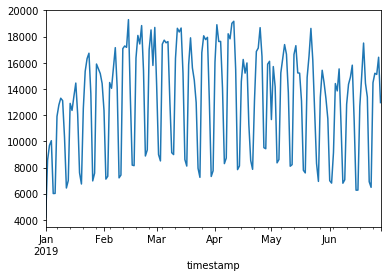

In [15]:
daily['repo'].plot()

## Estimate number of unique repositories

Expect the raw number of launches to be bigger than the number of repositories launched more than once. Those launched only once might have been accidents.

In [16]:
len(set(df.repo))

17081

In [17]:
from collections import Counter

sum(1 for k,v in Counter(df.repo).items() if v > 3)

8014

## Popular repositories and their branches

Twenty most popular repos:

In [18]:
top20 = df.groupby("repo").count().sort_values("timestamp", ascending=False).head(20)
top20

,origin,provider,timestamp,org,ref
repo,,,,,
ipython/ipython-in-depth,97857,1096129,1096129,1096129,1096129
jupyterlab/jupyterlab-demo,20716,242607,242607,242607,242607
ines/spacy-io-binder,9417,101270,101270,101270,101270
DS-100/textbook,6345,97981,97981,97981,97981
bokeh/bokeh-notebooks,4673,48752,48752,48752,48752
binder-examples/r,2667,35321,35321,35321,35321
rationalmatter/juno-demo-notebooks,2536,31552,31552,31552,31552
QuantStack/xeus-cling,2056,27093,27093,27093,27093
ines/spacy-course,2829,17411,17411,17411,17411


In [21]:
print("Cumulative top20 launches:", top20['ref'].sum())
print("The top20 repos are {:.1f}% of all "
      "launches.".format(100 * top20['ref'].sum() / df.shape[0]))

Cumulative top20 launches: 1824975
The top20 repos are 77.91% of all launches.


## Per org stats

Needs more RAM than mybinder.org gives us for now

In [ ]:
# add a new column showing total launches per repo
totals_per_repo = (df.groupby(["repo"])
 .size()
 .reset_index(name='repo_counts'))

In [ ]:
# add a nnew column showing total launches per org
totals_per_org = (df.groupby(["org"])
 .size()
 .reset_index(name='org_counts'))

In [ ]:
df_ = pd.merge(df, totals_per_repo, on='repo')
df_ = pd.merge(df_, totals_per_org, on='org')
#df_.sample(10)

In [ ]:
(df.groupby("provider")
   .size()
   .reset_index(name='Launches')
   .sort_values('Launches', ascending=False))

In [ ]:
(df_.groupby(["org", "repo", "ref", "repo_counts", "org_counts"])
 .size()
 # give the column a nice name
 .reset_index(name='ref_counts')
 # sort first by total launches, then within a repo by ref launches
 .sort_values(['org_counts', 'repo_counts', 'ref_counts'],
              ascending=[False,False, False])
 .set_index(["org", 'repo', 'ref'])
)